In this notebook, we aim to
1. cluster tests as datapoints, independently
2. find important lifestyle features making `score` within each cluster
3. predict the cluster for a new user to demonstrate most influential lifestyle factors

In the following, we try to simply implement one cycle from beginning to end, without any optimization.

# Step -1: Data

## Packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

## Data Preprocess

### Make unique id
define one `id` for both of them

In [3]:
df_om.user_id.unique, df_cgn.ID.unique

(<bound method Series.unique of 0      13
 1      13
 2      13
 3      13
 4      13
        ..
 491    72
 492    72
 493    73
 494    73
 495    73
 Name: user_id, Length: 496, dtype: int64>,
 <bound method Series.unique of 0       S01
 1       S01
 2       S01
 3       S01
 4       S01
        ... 
 1153    S13
 1154    S13
 1155    S13
 1156    S13
 1157    S13
 Name: ID, Length: 1158, dtype: object>)

In [4]:
df_om['id'] = 'om_' + df_om.user_id.astype(str)
df_om.id.unique()

array(['om_13', 'om_15', 'om_18', 'om_19', 'om_27', 'om_28', 'om_29',
       'om_35', 'om_37', 'om_38', 'om_40', 'om_49', 'om_51', 'om_54',
       'om_55', 'om_58', 'om_60', 'om_66', 'om_67', 'om_71', 'om_72',
       'om_73'], dtype=object)

In [5]:
df_cgn.ID.apply(
    lambda x: len(x)
).unique()
# check that the length for all of cgn ids is 3 chars

array([3])

In [6]:
df_cgn['id'] = 'cg_' + df_cgn.ID.apply(lambda x: x[1:])
df_cgn.id.unique()

array(['cg_01', 'cg_02', 'cg_03', 'cg_04', 'cg_05', 'cg_06', 'cg_07',
       'cg_08', 'cg_09', 'cg_10', 'cg_11', 'cg_12', 'cg_13'], dtype=object)

### Age

In [7]:
df_cgn[['id', 'user_age']].groupby('id').max().head()

user_age
id             
cg_01        30
cg_02        38
cg_03        38
cg_04        57
cg_05        26

In [8]:
# df_om[['id', 'user_year_of_birth']].groupby('id').max()
import datetime
df_om['user_age'] = datetime.datetime.now().year - df_om.user_year_of_birth
df_om[['id', 'user_age']].groupby('id').max().head()

user_age
id             
om_13        63
om_15        29
om_18        36
om_19        41
om_27        23

### Combine Datasets

In [9]:
df_data = pd.concat([df_om, df_cgn],
                    sort=False)

In [10]:
df_data = df_data.reset_index()
df_data['test_number'] = df_data.sort_values(
    by=['id', 'test_date']).groupby(by='id').cumcount()+1

In [11]:
df_data[['test_number', 'id', 'user_age']]

test_number     id  user_age
0               1  om_13        63
1               6  om_13        63
2               2  om_13        63
3               3  om_13        63
4               4  om_13        63
...           ...    ...       ...
1649           62  cg_13        48
1650           87  cg_13        48
1651           15  cg_13        48
1652           41  cg_13        48
1653           80  cg_13        48

[1654 rows x 3 columns]

### Valid ids

In [12]:
min_tests_req = 40

n_tests = df_data.groupby(by='id').test_id.count()
n_tests[n_tests > min_tests_req].reset_index()

id  test_id
0   cg_01       85
1   cg_02       78
2   cg_03       96
3   cg_05       85
4   cg_06       89
5   cg_07      106
6   cg_08      108
7   cg_09      112
8   cg_10       96
9   cg_11       98
10  cg_12      105
11  cg_13       91
12  om_13       94
13  om_18       50
14  om_40       43
15  om_51       42
16  om_55       57

In [13]:
valid_ids = list(n_tests[n_tests > min_tests_req].reset_index().id)

In [14]:
df_data[df_data.id.isin(valid_ids)].shape[0]/df_data.shape[0]
# this proportion of data is from users with valid number of tests taken

0.8675937122128174

### Define lifestyle Features

In [15]:
df_data = df_data.replace('not_set', np.nan)

In [16]:
# selected lifestyle factors

lifestyle_features = [
    'stimulant_doze',
    'sleep_time',
    'alcohol_doze',
    'heart_rate_avg',
#     'heart_rate_resting_avg',
#     'heart_rate_walking_avg',
#     'energy_burned_active',
    'energy_burned_resting',
    'steps_count',
#     'walking_distance',
    'exercise_hours',
    'climbed_flights_count',
]

### Datetime
https://www.google.com/search?q=encode+time+of+day+feature&sxsrf=ALeKk00MPdbhd-i4RcwEu7NKd_2OYZ60mQ:1600097956122&source=lnms&tbm=isch&sa=X&ved=2ahUKEwiJ856y_ejrAhUf83MBHYh3AZAQ_AUoAXoECA4QAw&biw=1389&bih=699#imgrc=AGI_OLXmV23c0M&imgdii=cFVytWvVjrnmjM

In [17]:
# encode the time of day as a one-hot vector

### Str2float

In [18]:
def str2float(df, features):
    for f in features:
#         print(f, '\n', df[f].unique(), '\n')
        df[f] = df[f].apply(lambda x: np.nan if pd.isna(x) else float(x))
    return df


str2float(df_data, lifestyle_features)[lifestyle_features]

stimulant_doze  sleep_time  alcohol_doze  heart_rate_avg  \
0                NaN         NaN           NaN          84.079   
1                3.0         6.0           NaN          83.664   
2                NaN         NaN           NaN          83.619   
3                NaN         NaN           NaN          83.816   
4                NaN         NaN           NaN          83.720   
...              ...         ...           ...             ...   
1649             0.0         7.5           0.0          60.927   
1650             0.0         7.5           0.0          63.948   
1651             0.0         6.0           0.0          61.329   
1652             4.0         7.5           0.0          63.624   
1653             0.0         7.5           0.0          66.700   

      energy_burned_resting  steps_count  exercise_hours  \
0                   978.547       2588.0           0.000   
1                   674.498       3549.0           0.100   
2                  1006.069       2588.0           0.000   
3                  1035.777       2888.0           0.000   
4                  1035.777       2888.0           0.000   
...                     ...          ...             ...   
1649               1385.380       3631.0           0.117   
1650               1576.518       6487.0           0.167   
1651               1457.740       5045.0           0.167   
1652               1260.848       5995.0           0.133   
1653               1469.796       6064.0           0.050   

      climbed_flights_count  
0                       5.0  
1                       3.0  
2                       5.0  
3                       5.0  
4                       5.0  
...                     ...  
1649                    4.0  
1650                    5.0  
1651                    3.0  
1652                    1.0  
1653                    1.0  

[1654 rows x 8 columns]

In [19]:
df_data = str2float(df_data, lifestyle_features)
# this one will convert strings to float, just for lifestyle_features

### Drop not numbers

In [20]:
df_data[lifestyle_features].shape, df_data[lifestyle_features].dropna().shape
# WARNING: if you dropna() for a set of features, you'll lost all the rest columns

((1654, 8), (1377, 8))

### Select Metrics & Features

#### metrics

In [21]:
metrics = ['score',
           'accuracy',
#            'speed',
           'mean_rt',
#            'no_responses_count',
#            'outliers_count',
#            'images_tested',
           ]

In [22]:
for metric in metrics:
    print(df_data[metric].isna().unique())
# no metric is nullable

[False]
[False]
[False]


In [23]:
df_data[metrics].head()

score  accuracy  mean_rt
0    93.1147      94.0  360.286
1    92.0000      92.0  333.278
2    86.0000      86.0  342.699
3    87.6344      88.0  358.436
4    88.6721      90.0  364.190

#### hard features

In [24]:
# df_data[['user_age', 'user_gender']].iloc[1000:1100]
df_data.user_gender.unique()
df_data[['user_age', 'user_gender', 'user_vision']]

user_age user_gender user_vision
0           63      female         NaN
1           63      female         NaN
2           63      female         NaN
3           63      female         NaN
4           63      female         NaN
...        ...         ...         ...
1649        48      female   corrected
1650        48      female   corrected
1651        48      female   corrected
1652        48      female   corrected
1653        48      female   corrected

[1654 rows x 3 columns]

/home/qasem/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


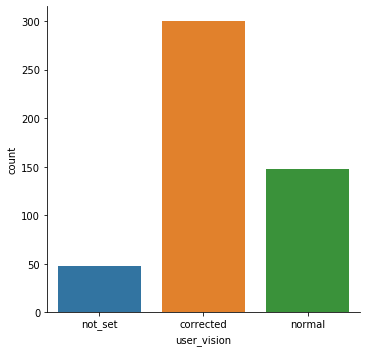

In [25]:
sns.factorplot('user_vision', data=df_om, kind="count")
# df_om[['user_age', 'user_gender', 'user_vision']]

In [26]:
df_data.drop(df_data[df_data.user_vision=='not_set'].index).shape, df_data.shape

((1654, 176), (1654, 176))

In [27]:
hard_features = [
    'user_age',
#     'user_vision',
#     'user_gender',
]

#### * all selected features

In [86]:
# selected_features = ['id']
# selected_features.extend(lifestyle_features)
# selected_features.extend(metrics)
# selected_features.extend(hard_features)

selected_features = [
     'id',
     'stimulant_doze',
     'sleep_time',
     'alcohol_doze',
     'heart_rate_avg',
#      'energy_burned_resting',
#      'steps_count',
#      'exercise_hours',
#      'climbed_flights_count',
     'score',
#      'accuracy',
#      'mean_rt',
     'user_age'
    ]

selected_features

['id',
 'stimulant_doze',
 'sleep_time',
 'alcohol_doze',
 'heart_rate_avg',
 'score',
 'user_age']

In [87]:
#todo for fewer features, you should drop less and select only those features

df_data[selected_features].dropna().shape, df_data.dropna(subset=selected_features).shape, df_data.shape
# df_data[df_data[selected_features].notna()].shape, df_data.shape
# df_data.shape

((1377, 7), (1377, 177), (1654, 177))

In [88]:
df_data.id

0       om_13
1       om_13
2       om_13
3       om_13
4       om_13
        ...  
1649    cg_13
1650    cg_13
1651    cg_13
1652    cg_13
1653    cg_13
Name: id, Length: 1654, dtype: object

# Step 0: Data Visualization to Estimate
The main reason is to estimate the number of clusters

In [31]:
# define nid to be unique numeric id
print(df_data['id'].astype('category').cat.codes.nunique())
df_data['nid'] = df_data['id'].astype('category').cat.codes

35


## Select Features to show

### With mutual information
I selected a subset of features that have less mutual information 

## t-SNE Visualization

### t-SNE vs PCA vs Isomap 

In [32]:
import random


def gen_colors(df):
    n_colors = df_data.id.nunique()
    colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(n_colors)]
    colors = {}
    for i in df_data.id.unique():
        colors[i] = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
    return colors

# gen_colors(df_data)

the shape of df: (1284, 7)
features are: ['stimulant_doze', 'sleep_time', 'alcohol_doze', 'heart_rate_avg', 'score', 'user_age', 'id']


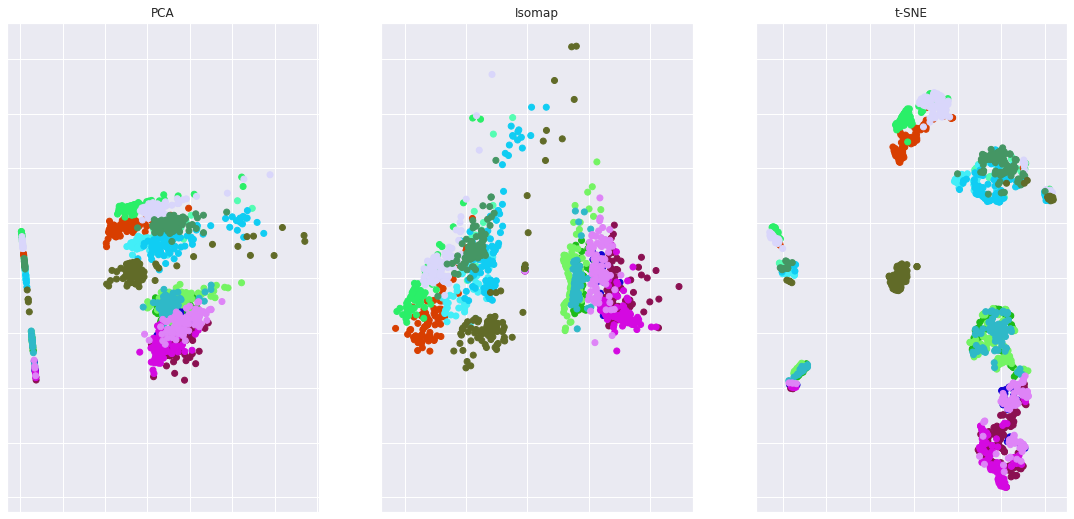

In [91]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

from functools import partial
# from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold
from sklearn.decomposition import PCA


def plot_manifolds(df):

#     features = []
#     features.extend(lifestyle_features)
#     features.extend(metrics)
    
    features = list(df.columns)
    features.remove('id')
#     print(features)
    
    X = df[features]
    features.extend(['id'])
#     print(features)
    df = df[features]
    print('the shape of df:', df.shape)
    print('features are:', features)
    
    colors = gen_colors(df)
#     print(colors)
#     , np.array(df[['score']])/100*255

    random_state = 100
    n_neighbors = 50
    n_components = 2
    perplexity = 30
    n_iter = 5000
    
#     LLE = partial(manifold.LocallyLinearEmbedding,
#                   n_neighbors, n_components, eigen_solver='auto')
    # Set-up manifold methods
    methods = {}
    methods['PCA'] = PCA(n_components=n_components,
                         random_state=random_state,
                         svd_solver='full')
    # methods['LLE'] = LLE(method='standard')
    # methods['LTSA'] = LLE(method='ltsa')
    # methods['Hessian LLE'] = LLE(method='hessian')
#     methods['Modified LLE'] = LLE(method='modified')
    methods['Isomap'] = manifold.Isomap(n_neighbors=n_neighbors,
                                        n_components=n_components)
    methods['t-SNE'] = manifold.TSNE(n_components=n_components,
                                     init='pca',
#                                      init='random',
                                     n_iter=n_iter,
                                     random_state=random_state,
                                     perplexity=perplexity)
    
    # Create figure
    fig, ax = plt.subplots(1, len(methods), figsize=(19, 9), sharey=True)
    
    # Plot results
    for i, (label, method) in enumerate(methods.items()):
        Y = method.fit_transform(X)
#         print(df['id'].apply(lambda x: colors[x]))
        ax[i].scatter(Y[:, 0], Y[:, 1],
                   c=df['id'].apply(lambda x: colors[x]),
                   cmap=plt.cm.Spectral)
        ax[i].set_title("%s" % label)
        ax[i].xaxis.set_major_formatter(NullFormatter())
        ax[i].yaxis.set_major_formatter(NullFormatter())
        ax[i].axis('tight')

    plt.show()


df_data_selected = df_data[selected_features].dropna()
# df_data_selected = df_cgn[['steps_preceding_7_days',
#                            'sleep_time', 'score',
#                            'energy_burned_resting',
#                            'user_age', 'id']].dropna()
# print(selected_features, df_data_selected.shape)
plot_manifolds(df_data_selected[df_data_selected.id.isin(valid_ids)])

### [sklearn perplex example](https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html)
Trying different perplexities may help to get better visualization.

> The larger the perplexity, the more non-local information will be retained in the dimensionality reduction result. 

[![enter image description here][1]][1]

[1]: https://i.stack.imgur.com/wVa2f.png

source: [stats.stackexchange: Why does larger perplexity tend to produce clearer clusters in t-SNE?](https://stats.stackexchange.com/questions/399868/why-does-larger-perplexity-tend-to-produce-clearer-clusters-in-t-sne)

### t-SNE from [bioinfokit](https://reneshbedre.github.io/blog/tsne.html)

Check out the bioinfokit-code-results directory for the saved graphs. 

In [34]:
# import sys
# !{sys.executable} -m pip install bioinfokit --user

In [35]:
# from sklearn.manifold import TSNE
# from bioinfokit.visuz import cluster


# def plot_tsne(df):
#     factors = ['nid']
#     factors.extend(lifestyle_features)
#     features = factors
#     features.extend(metrics)
#     df = df[factors]
    
#     tsne_em = TSNE(n_components=2, perplexity=30.0, n_iter=10000, verbose=1).fit_transform(df)
#     cluster.tsneplot(score=tsne_em)
# #     color_class = df['nid'].to_numpy()
#     color_class = df['nid']
#     cluster.tsneplot(score=tsne_em,
#                      colorlist=color_class,
#                      legendpos='upper right',
#                      legendanchor=(1.15, 1))

# plot_tsne(df_data)

### t-SNE from [tds](https://towardsdatascience.com/t-sne-python-example-1ded9953f26)

#### The raw code

In [92]:
import numpy as np
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)


# X, y = load_digits(return_X_y=True)

# MACHINE_EPSILON = np.finfo(np.double).eps
# n_components = 2
# perplexity = 30

# X.shape

In [93]:
# def fit(X):
#     n_samples = X.shape[0]
    
#     # Compute euclidean distance
#     distances = pairwise_distances(X, metric='euclidean', squared=True)
    
#     # Compute joint probabilities p_ij from distances.
#     P = _joint_probabilities(distances=distances, desired_perplexity=perplexity, verbose=False)
    
#     # The embedding is initialized with iid samples from Gaussians with standard deviation 1e-4.
#     X_embedded = 1e-4 * np.random.mtrand._rand.randn(n_samples, n_components).astype(np.float32)
    
#     # degrees_of_freedom = n_components - 1 comes from
#     # "Learning a Parametric Embedding by Preserving Local Structure"
#     # Laurens van der Maaten, 2009.
#     degrees_of_freedom = max(n_components - 1, 1)
    
#     return _tsne(P, degrees_of_freedom, n_samples, X_embedded=X_embedded)


# def _tsne(P, degrees_of_freedom, n_samples, X_embedded):
#     params = X_embedded.ravel()
    
#     obj_func = _kl_divergence
#     params = _gradient_descent(obj_func, params, [P, degrees_of_freedom, n_samples, n_components])
        
#     X_embedded = params.reshape(n_samples, n_components)
#     return X_embedded


# def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components):
#     X_embedded = params.reshape(n_samples, n_components)
    
#     dist = pdist(X_embedded, "sqeuclidean")
#     dist /= degrees_of_freedom
#     dist += 1.
#     dist **= (degrees_of_freedom + 1.0) / -2.0
#     Q = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)
    
#     # Kullback-Leibler divergence of P and Q
#     kl_divergence = 2.0 * np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    
#     # Gradient: dC/dY
#     grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
#     PQd = squareform((P - Q) * dist)
#     for i in range(n_samples):
#         grad[i] = np.dot(np.ravel(PQd[i], order='K'),
#                          X_embedded[i] - X_embedded)
#     grad = grad.ravel()
#     c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
#     grad *= c
#     return kl_divergence, grad


# def _gradient_descent(obj_func, p0, args, it=0, n_iter=1000,
#                       n_iter_check=1, n_iter_without_progress=300,
#                       momentum=0.8, learning_rate=200.0, min_gain=0.01,
#                       min_grad_norm=1e-7):
    
#     p = p0.copy().ravel()
#     update = np.zeros_like(p)
#     gains = np.ones_like(p)
#     error = np.finfo(np.float).max
#     best_error = np.finfo(np.float).max
#     best_iter = i = it
    
#     for i in range(it, n_iter):
#         error, grad = obj_func(p, *args)
#         grad_norm = linalg.norm(grad)
#         inc = update * grad < 0.0
#         dec = np.invert(inc)
#         gains[inc] += 0.2
#         gains[dec] *= 0.8
#         np.clip(gains, min_gain, np.inf, out=gains)
#         grad *= gains
#         update = momentum * update - learning_rate * grad
#         p += update
#         print("[t-SNE] Iteration %d: error = %.7f,"
#                               " gradient norm = %.7f"
#                               % (i + 1, error, grad_norm))
        
#         if error < best_error:
#                 best_error = error
#                 best_iter = i
#         elif i - best_iter > n_iter_without_progress:
#             break
        
#         if grad_norm <= min_grad_norm:
#             break
#     return p

#### applying on data

In [38]:
# def t_sne_tds1(df):
#     features = []
#     features.extend(lifestyle_features)
#     features.extend(metrics)
    
#     X = df[features]
#     features.extend(['nid', 'id'])
#     df = df[features]
    
#     return fit(X)


# X_emb1 = t_sne_tds1(df_data)

In [39]:
# sns.scatterplot(X_emb[:,0], X_emb[:,1],
#                 hue=df_data['id'],
#                 legend='full',
#                 palette=sns.color_palette('bright', df_data.id.nunique()),
# #                 markers=True,
# #                 style=df_data[df_data.id=='om_35']['id'],
#                )

In [40]:
# sns.scatterplot(X_emb1[:,0], X_emb1[:,1],
#                 hue=df_data['id'],
# #                 legend='full',
#                 legend=False,
#                 palette=sns.color_palette('bright', df_data.id.nunique()),
#                )

# sns.scatterplot(X_emb1[:,0], X_emb1[:,1],
#                 hue=df_data['id'],
#                 legend=False,
#                 palette=sns.color_palette('bright', df_data.id.nunique()),
#                 s=400,
#                 markers=['X'],
#                 style=df_data[df_data.id=='om_13']['id'],
#                )

#### * Using sklearn

In [70]:
def t_sne_tds2(df, n_iter=6000, perplexity=70):
    features = list(df.columns)
    features.remove('id')
#     print(features)
    
    X = df[features]
    features.extend(['id'])
#     print(features)
    df = df[features]
    print('the shape of df:', df.shape)
    print('features are:', features)
    
    tsne = TSNE(
        n_iter=n_iter,
        random_state=100,
        perplexity=perplexity
    )

    return tsne.fit_transform(X)

the shape of df: (1284, 7)
features are: ['stimulant_doze', 'sleep_time', 'alcohol_doze', 'heart_rate_avg', 'score', 'user_age', 'id']


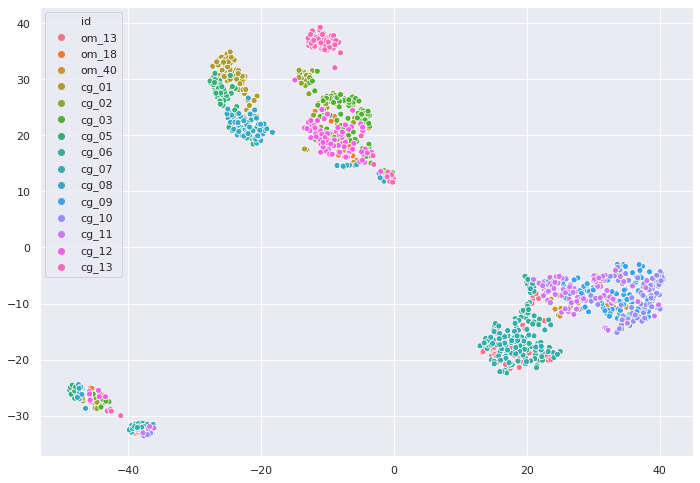

In [102]:
df_data_selected = df_data[selected_features].dropna()
# mean for some features like alcohol_doze, activity
# plus test features for some others
X_emb = t_sne_tds2(df_data_selected[df_data_selected.id.isin(valid_ids)])

sns.scatterplot(X_emb[:,0], X_emb[:,1],
                legend='full', hue=df_data_selected[df_data_selected.id.isin(valid_ids)].id)

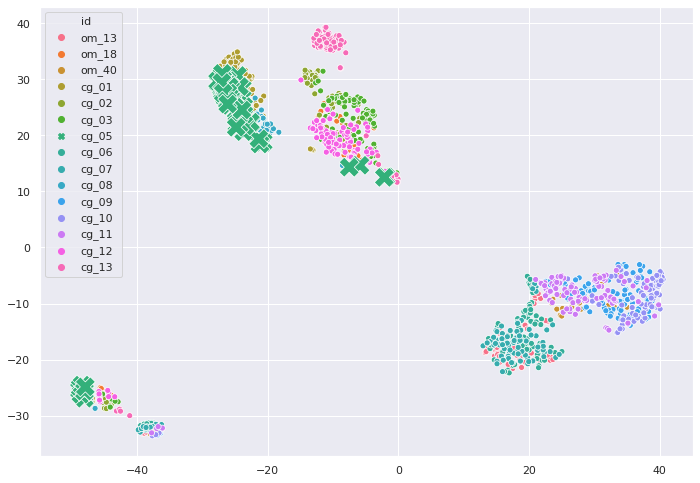

In [103]:
sns.scatterplot(X_emb[:,0], X_emb[:,1],
                hue=df_data_selected[df_data_selected.id.isin(valid_ids)]['id'],
#                 legend='full',
                legend=False,
                markers=['x', 'o'],
               )

sns.scatterplot(X_emb[:,0], X_emb[:,1],
                hue=df_data_selected[df_data_selected.id.isin(valid_ids)]['id'],
#                 legend=False,
                s=400,
                markers=['X'],
                style=df_data_selected[df_data_selected.id=='cg_05']['id']
               )

In [95]:
df_data[selected_features].columns[(df_data[selected_features] != 0).all()]
# gets back the columns which has no zero value at any row

Index(['id', 'user_age'], dtype='object')

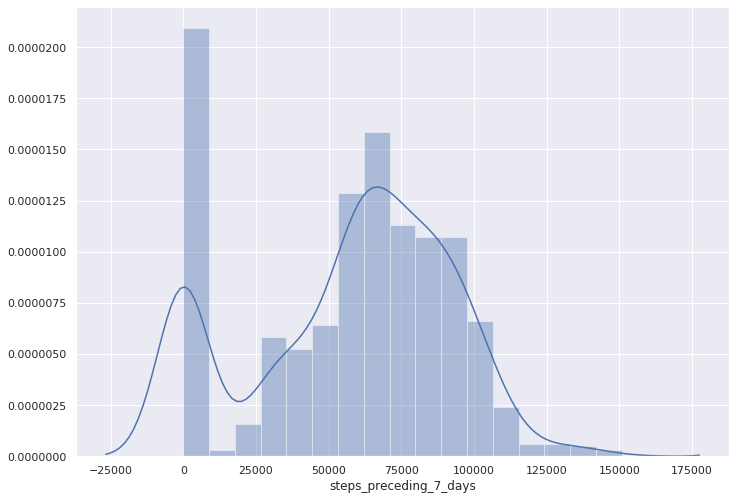

In [44]:
sns.distplot(df_cgn.steps_preceding_7_days)

In [104]:
# df_data_selected = df_cgn[df_cgn.steps_preceding_7_days!=0][['id', 'score','steps_preceding_7_days', 'user_age']].dropna()
# df_data_selected = df_data[selected_features].dropna()
# df_data_selected = df_cgn[['id', 'score', 'user_age']].dropna()
# mean for some features like alcohol_doze, activity
# plus test features for some others

# X_emb = t_sne_tds2(df_data_selected[df_data_selected.id.isin(valid_ids)], n_iter=1000, perplexity=20)

# sns.scatterplot(X_emb[:,0], X_emb[:,1],
#                 legend='full', hue=df_data_selected[df_data_selected.id.isin(valid_ids)]['id'])

# sns.scatterplot(X_emb[:,0], X_emb[:,1],
#                 hue=df_data_selected[df_data_selected.id.isin(valid_ids)]['id'],
#                 legend=False,
# #                 c='black',
#                 s=400,
#                 markers=['X'],
#                 style=df_data[df_data.id=='cg_09']['id'],
#                )

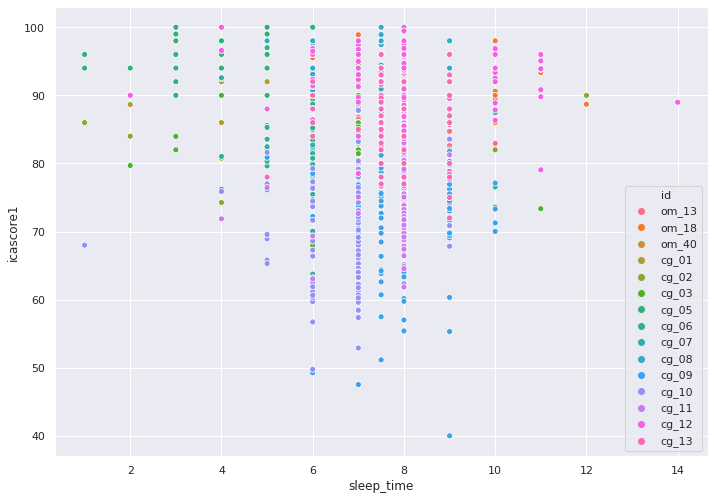

In [106]:
sns.scatterplot(x= 'sleep_time', y='score',
    data=df_data_selected[df_data_selected.id.isin(valid_ids)],
                hue=df_data_selected[df_data_selected.id.isin(valid_ids)]['id'],
                legend='full',
               )

### For selected features
These features are selected using mutual information.

It might be better that applying t-sne on all `lifestyle_features`

In [107]:
# features_selected = [
#     'sleep_time',
#     'stimulant_doze',
#     'alcohol_doze',
#     'heart_rate_avg',
# #     'energy_burned_resting',
# #     'steps_count',
# #     'exercise_hours',
#     'climbed_flights_count',
# ]

In [82]:
# def t_sne_tds_sel(df):
#     features = []
#     features.extend(features_selected)
#     features.extend(metrics)
    
#     X = df[features]
#     features.extend(['nid', 'id'])
#     df = df[features]
    
#     tsne = TSNE()

#     return tsne.fit_transform(X)


# X_emb_sel = t_sne_tds_sel(df_data[df_data.id.isin(valid_ids)])

In [ ]:
# def show_t_sne(X_emb_sel):
#     sns.scatterplot(X_emb_sel[:,0], X_emb_sel[:,1],
#                     hue=df_data[df_data.id.isin(valid_ids)]['id'],
#                     legend='full',
#                     palette=sns.color_palette('bright',
#                                              df_data[df_data.id.isin(valid_ids)].id.nunique())
#                    )


# show_t_sne(X_emb_sel)

In [ ]:
# def show_one_user_t_sne(user_id, X_emb_sel):
#     sns.scatterplot(X_emb_sel[:,0], X_emb_sel[:,1],
#                     hue=df_data[df_data.id.isin(valid_ids)]['id'],
# #                     legend=False,
#                     palette=sns.color_palette('bright',
#                                              df_data[df_data.id.isin(valid_ids)].id.nunique())
#                    )
#     sns.scatterplot(X_emb_sel[:,0], X_emb_sel[:,1],
#                     hue=df_data[df_data.id.isin(valid_ids)]['id'],
#                     legend=False,
#                     s=400,
#                     markers=['X'],
#                     style=df_data[df_data.id.isin(valid_ids)][df_data.id==user_id]['id'],
#                    )
    

# # select the user_id from legend 
# show_one_user_t_sne('om_40', X_emb_sel)

# Step 1: Clustering

## * Search for Elbow (Step 0)
To find number of clusters using k-means algorithm

In [83]:
df_om[df_om.user_vision=='not_set'].shape[0]/df_om.shape[0]

0.0967741935483871

the shape of df: (1284, 7)


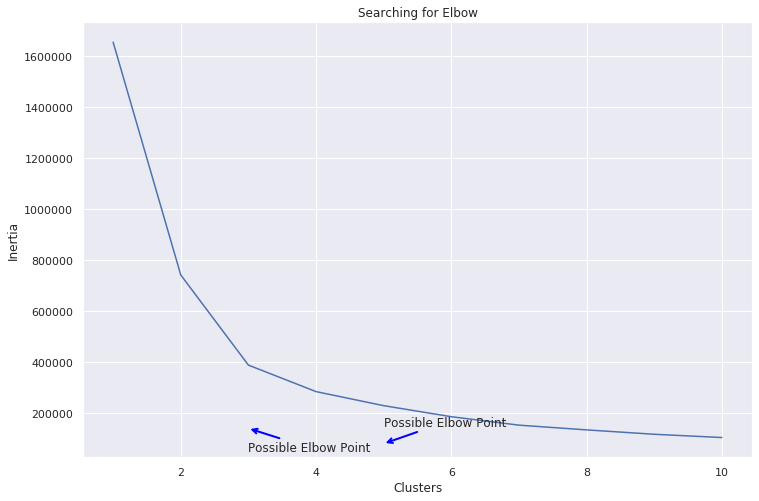

In [108]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


def clustering_kmeans_elbow(df):
    # Let's see our data in a detailed way with pairplot
    
#     sns.pairplot(df[['score', 'exercise_hours', 'stimulant_doze']],
#                  aspect=1.5)
#     plt.show()

    features = list(df.columns)
    features.remove('id')
#     print(features)
    
    X = df[features]
    features.extend(['id'])
#     print(features)
    df = df[features]
    print('the shape of df:', df.shape)
#     print('features are:', features)
    
    clusters = []

    for i in range(1, 11):
        km = KMeans(n_clusters=i).fit(X)
        clusters.append(km.inertia_)

    fig, ax = plt.subplots(figsize=(12, 8))
    sns.lineplot(x=list(range(1, 11)), y=clusters, ax=ax)
    ax.set_title('Searching for Elbow')
    ax.set_xlabel('Clusters')
    ax.set_ylabel('Inertia')

    # Annotate arrow
    ax.annotate('Possible Elbow Point', xy=(3, 140000), xytext=(3, 50000), xycoords='data',          
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))

    ax.annotate('Possible Elbow Point', xy=(5, 80000), xytext=(5, 150000), xycoords='data',          
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))

    plt.show()


df_data_selected = df_data[selected_features].dropna()
# print(selected_features, df_data_selected.shape)
clustering_kmeans_elbow(df_data_selected[df_data_selected.id.isin(valid_ids)])

In [111]:
n_clusters = 3

## K-means
With [kaggle tutorial](https://www.kaggle.com/fazilbtopal/popular-unsupervised-clustering-algorithms/notebook)

the shape of df: (1284, 7)


/home/qasem/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/qasem/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


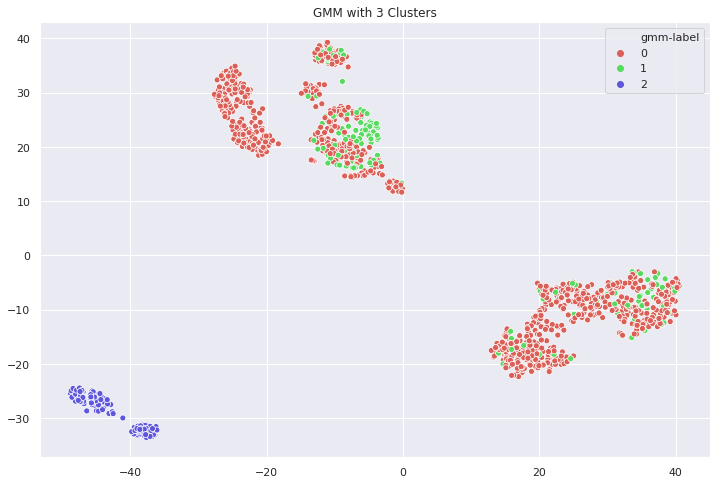

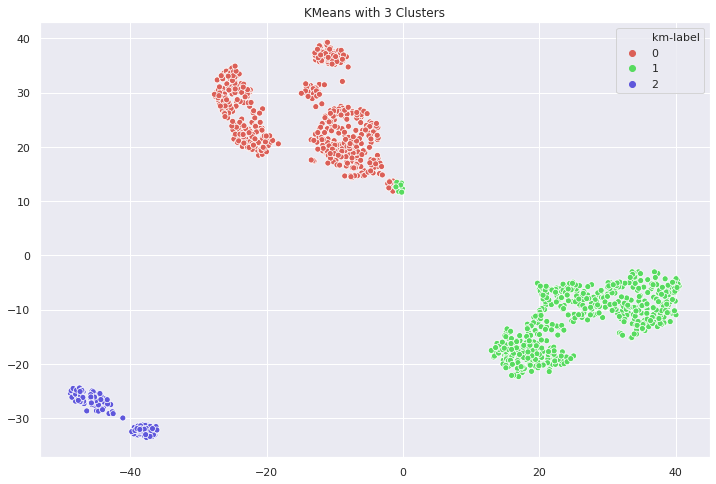

In [149]:
def show_clusters(df, X_emb, n_clusters):
    features = list(df.columns)
    features.remove('id')
#     print(features)
    
    X = df[features]
    features.extend(['id'])
#     print(features)
    df = df[features]
    print('the shape of df:', df.shape)
#     print('features are:', features)
        
    gmm = mixture.GaussianMixture(n_components=n_clusters,
                                  covariance_type='full')
    km = KMeans(n_clusters=n_clusters).fit(X)
    
    gmm.fit(X)
    df['gmm-label'] = X['gmm-label'] = gmm.predict(X)
    df['km-label'] = X['km-label'] = km.labels_
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(X_emb[:,0], X_emb[:,1], hue=X['gmm-label'], 
                    palette=sns.color_palette('hls', n_clusters))
    plt.title('GMM with ' + str(n_clusters) + ' Clusters')
    plt.show()
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(X_emb[:,0], X_emb[:,1], hue=X['km-label'], 
                    palette=sns.color_palette('hls', n_clusters))
    plt.title('KMeans with ' + str(n_clusters) + ' Clusters')
    plt.show()

    return df


# show_clusters(, X_emb_sel)   
# X_emb_sel.shape, df_data[df_data.id.isin(valid_ids)].shape

df_data_selected = df_data[selected_features].dropna()
# print(selected_features, df_data_selected.shape)
df_data_selected = show_clusters(df_data_selected[df_data_selected.id.isin(valid_ids)],
              X_emb, n_clusters)

    In the plot, shown above, Kmeans has been conducted in data with dim of 19 (metrics+features_selected). Then, with the calculated labels, we plot labeled datapoints in a t-SNE visiulalization.

the shape of df: (1284, 7)
features are: ['stimulant_doze', 'sleep_time', 'alcohol_doze', 'heart_rate_avg', 'score', 'user_age', 'id']


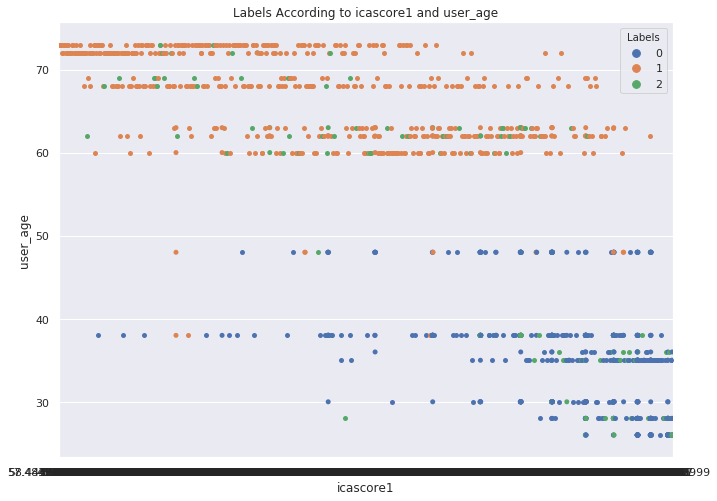

In [113]:
def show_kmeans_categorical(df, x, y):
    features = list(df.columns)
    features.remove('id')
#     print(features)
    
    X = df[features]
    features.extend(['id'])
#     print(features)
    df = df[features]
    print('the shape of df:', df.shape)
    print('features are:', features)
    
    km = KMeans(n_clusters=n_clusters).fit(X)
    X['Labels'] = km.labels_
    
#     plt.figure(figsize=(20,8))
#     ax = fig.add_subplot(121)
#     sns.swarmplot(x=x, y=y, data=X, ax=ax)
#     ax.set_title('Labels According to ' + x)

#     ax = fig.add_subplot(122)
    plt.figure(figsize=(11, 8))
    ax = sns.swarmplot(x=x, y=y,
                  data=X,
                  hue='Labels'
                 )
    ax.set_title('Labels According to ' + x + ' and ' + y)
    plt.show()
    

df_data_selected = df_data[selected_features].dropna()
# print(selected_features, df_data_selected.shape)
show_kmeans_categorical(df_data_selected[df_data_selected.id.isin(valid_ids)],
                       'score',
                        'user_age',
                       )
# we should try and guess features which might illustrate clusters

## Try different methods
The figure simply shows the main idea. Here, I selected Mini Batch K-means, DBSCAN, and Gaussian Mixture Model to compare.

[![enter image description here][1]][1]

[1]: https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png

source: [sklearn: Comparing different clustering algorithms on toy datasets](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py)

In [122]:
import time
import warnings

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice


np.random.seed(10)

# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times


n_samples = 1000
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
# noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
# blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# print(X.shape,y.shape)

# Set up cluster parameters

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
#     (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
#     (aniso, {'eps': .15, 'n_neighbors': 2,
#              'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
#     (blobs, {}),
#     (no_structure, {})
    ]

In [123]:
# plt.figure(figsize=(9 * 2 + 3, 12.5))
# plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
#                     hspace=.01)


# plot_num = 1


# for i_dataset, (dataset, algo_params) in enumerate(datasets):
#     # update parameters with dataset-specific values
#     params = default_base.copy()
#     params.update(algo_params)

#     X, y = dataset

#     # normalize dataset for easier parameter selection
#     X = StandardScaler().fit_transform(X)

#     # estimate bandwidth for mean shift
#     bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

#     # connectivity matrix for structured Ward
#     connectivity = kneighbors_graph(
#         X, n_neighbors=params['n_neighbors'], include_self=False)
#     # make connectivity symmetric
#     connectivity = 0.5 * (connectivity + connectivity.T)

    
#     # ============
#     # Create cluster objects
#     # ============
# #     ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
#     two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
# #     ward = cluster.AgglomerativeClustering(
# #         n_clusters=params['n_clusters'], linkage='ward',
# #         connectivity=connectivity)
# #     spectral = cluster.SpectralClustering(
# #         n_clusters=params['n_clusters'], eigen_solver='arpack',
# #         affinity="nearest_neighbors")
#     dbscan = cluster.DBSCAN(eps=params['eps'])
# #     optics = cluster.OPTICS(min_samples=params['min_samples'],
# #                             xi=params['xi'],
# #                             min_cluster_size=params['min_cluster_size'])
# #     affinity_propagation = cluster.AffinityPropagation(
# #         damping=params['damping'], preference=params['preference'])
# #     average_linkage = cluster.AgglomerativeClustering(
# #         linkage="average", affinity="cityblock",
# #         n_clusters=params['n_clusters'], connectivity=connectivity)
# #     birch = cluster.Birch(n_clusters=params['n_clusters'])
#     gmm = mixture.GaussianMixture(
#         n_components=params['n_clusters'], covariance_type='full')

#     clustering_algorithms = (
#         ('M.B.k-means', two_means),
# #         ('AffinityPropagation', affinity_propagation),
# #         ('MeanShift', ms),
# #         ('SpectralClustering', spectral),
# #         ('Ward', ward),
# #         ('AgglomerativeClustering', average_linkage),
#         ('DBSCAN', dbscan),
# #         ('OPTICS', optics),
# #         ('Birch', birch),
#         ('Gaussian Mixture Model', gmm)
#     )

#     for name, algorithm in clustering_algorithms:
#         t0 = time.time()

#         # catch warnings related to kneighbors_graph
#         with warnings.catch_warnings():
#             warnings.filterwarnings(
#                 "ignore",
#                 message="the number of connected components of the " +
#                 "connectivity matrix is [0-9]{1,2}" +
#                 " > 1. Completing it to avoid stopping the tree early.",
#                 category=UserWarning)
#             warnings.filterwarnings(
#                 "ignore",
#                 message="Graph is not fully connected, spectral embedding" +
#                 " may not work as expected.",
#                 category=UserWarning)
#             algorithm.fit(X)

#         t1 = time.time()
#         if hasattr(algorithm, 'labels_'):
#             y_pred = algorithm.labels_.astype(np.int)
#         else:
#             y_pred = algorithm.predict(X)

#         plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
#         if i_dataset == 0:
#             plt.title(name, size=18)

#         colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
#                                              '#f781bf', '#a65628', '#984ea3',
#                                              '#999999', '#e41a1c', '#dede00']),
#                                       int(max(y_pred) + 1))))
        
#         # add black color for outliers (if any)
#         colors = np.append(colors, ["#000000"])
#         plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

#         plt.xlim(-2.5, 2.5)
#         plt.ylim(-2.5, 2.5)
#         plt.xticks(())
#         plt.yticks(())
#         plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
#                  transform=plt.gca().transAxes, size=15,
#                  horizontalalignment='right')
#         plot_num += 1

# plt.show()

## Gaussian Mixture Model

> Comparison of k-means and EM on artificial data visualized with ELKI. Using the variances, the EM algorithm can describe the normal distributions exactly, while k-means splits the data in Voronoi-cells. The cluster center is indicated by the lighter, bigger symbol.

[![enter image description here][1]][1]

[1]: https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/ClusterAnalysis_Mouse.svg/2880px-ClusterAnalysis_Mouse.svg.png

source: [Wikipedia: Expectation–maximization algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm)

In [124]:
# df_data_selected = df_data[['id', 'heart_rate_avg', 'steps_count', 'score', 'user_age']].dropna()
df_data_selected = df_data[selected_features].dropna()
X_emb.shape, df_data_selected[df_data_selected.id.isin(valid_ids)].shape

((1284, 2), (1284, 7))

In [150]:
# import time
# import warnings

# from sklearn import cluster, datasets, mixture
# from sklearn.neighbors import kneighbors_graph
# from sklearn.preprocessing import StandardScaler
# from itertools import cycle, islice

# def clustering_show(df, X_emb):
# #     np.random.seed(100)

#     features = list(df.columns)
#     features.remove('id')
# #     print(features)
    
#     data = X = df[features]
#     features.extend(['id'])
#     df = df[features]
#     print('the shape of df:', df.shape)
#     print('features are:', features)

#     # Set up cluster parameters

#     plt.figure(figsize=(15, 9))
#     plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

#     plot_num = 1

#     default_base = {
#                     'quantile': .3,
#                     'eps': .3,
#                     'damping': .9,
#                     'preference': -200,
#                     'n_neighbors': 10,
#                     'n_clusters': 3,
#                     'min_samples': 20,
#                     'xi': 0.05,
#                     'min_cluster_size': 0.1
#     }

#     datasets = [(data, {'n_clusters': n_clusters})]

#     for i_dataset, (dataset, algo_params) in enumerate(datasets):
        
#         # update parameters with dataset-specific values
#         params = default_base.copy()
#         params.update(algo_params)

#         X = dataset

#         # normalize dataset for easier parameter selection
#         X = StandardScaler().fit_transform(X)

#         # estimate bandwidth for mean shift
#         bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

#         # connectivity matrix for structured Ward
#         connectivity = kneighbors_graph(
#             X, n_neighbors=params['n_neighbors'], include_self=False)
#         # make connectivity symmetric
#         connectivity = 0.5 * (connectivity + connectivity.T)


#         # ============
#         # Create cluster objects
#         # ============
# #         print('# of clusters', params['n_clusters'])

# #         two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
#         two_means = cluster.KMeans(n_clusters=params['n_clusters'])
#         gmm = mixture.GaussianMixture(
#             n_components=params['n_clusters'], covariance_type='full')
        
#         clustering_algorithms = (
#             ('KMeans', two_means),
#             ('Gaussian Mixture Model', gmm)
#         )

#         for name, algorithm in clustering_algorithms:
#             t0 = time.time()

#             # catch warnings related to kneighbors_graph
#             with warnings.catch_warnings():
#                 warnings.filterwarnings(
#                     "ignore",
#                     message="the number of connected components of the " +
#                     "connectivity matrix is [0-9]{1,2}" +
#                     " > 1. Completing it to avoid stopping the tree early.",
#                     category=UserWarning)
#                 warnings.filterwarnings(
#                     "ignore",
#                     message="Graph is not fully connected, spectral embedding" +
#                     " may not work as expected.",
#                     category=UserWarning)
#                 algorithm.fit(X)

#             t1 = time.time()
#             if hasattr(algorithm, 'labels_'):
#                 y_pred = algorithm.labels_.astype(np.int)
#             else:
#                 y_pred = algorithm.predict(X)

#             plt.subplot(1, len(clustering_algorithms), plot_num)
#             if i_dataset == 0:
#                 plt.title(name, size=18)
                
#             raw_colors = [
#                 'orange', 'lightgreen', 'red',
# #                 'aqua', 'cyan',
#             ]
#             colors = np.array(list(islice(cycle(raw_colors),
#                                           int(max(y_pred) + 1))))

#             # add black color for outliers (if any)
#             colors = np.append(colors, ["#000000"])
#             plt.scatter(X_emb[:, 0], X_emb[:, 1], s=8, color=colors[y_pred])

# #             plt.xticks(())
# #             plt.yticks(())
#             plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
#                      transform=plt.gca().transAxes, size=15,
#                      horizontalalignment='right')
#             plot_num += 1

#     plt.show()
    
    
# df_data_selected = df_data[selected_features].dropna()
# clustering_show(df_data_selected[df_data_selected.id.isin(valid_ids)], X_emb)

# Step 2: Influential Features within Cluster
## Shapely value

In [154]:
def pred_label_gmm(df, X_emb, n_clusters):
    
    features = list(df.columns)
    features.remove('id')
#     print(features)
    
    data = X = df[features]
    features.extend(['id'])
#     print(features)
    df = df[features]
    print('the shape of df:', df.shape)
#     print('features are:', features)

    
    gmm = mixture.GaussianMixture(n_components=n_clusters,
                                  covariance_type='full')
    gmm.fit(X)
    y_pred = gmm.predict(X)
    df['gmm-label'] = y_pred
#     sns.scatterplot(X_emb[:,0], X_emb[:,1],
#                 hue=y_pred,
#                 legend='full',
#                 palette=sns.color_palette('bright', n_clusters))
    return df

In [155]:
df_data_selected.head()

stimulant_doze  sleep_time  alcohol_doze  heart_rate_avg  score  \
6              4.0         8.0           0.0          78.583    91.2848   
7              4.0         8.0           0.0          78.345    79.0736   
8              3.0         8.0           0.0          95.838    76.2889   
9              4.0         8.0           0.0          76.286    73.7078   
10             5.0         8.0           0.0          77.810    80.0000   

    user_age     id  gmm-label  km-label  
6         63  om_13          0         1  
7         63  om_13          0         1  
8         63  om_13          0         1  
9         63  om_13          0         1  
10        63  om_13          0         1

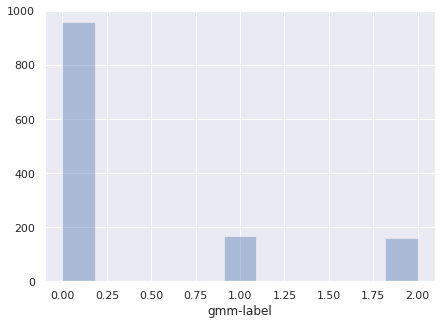

gmm-label     id
6           0  om_13
7           0  om_13
8           0  om_13
9           0  om_13
10          0  om_13

In [164]:
# df_data_selected = df_data[selected_features].dropna()
# df_valid = pred_label_gmm(df_data_selected[df_data_selected.id.isin(valid_ids)],
#                           X_emb, n_clusters)

plt.figure(figsize=(7,5))
sns.distplot(df_data_selected['gmm-label'], kde=False)
plt.show()
df_data_selected[['gmm-label', 'id']].head()

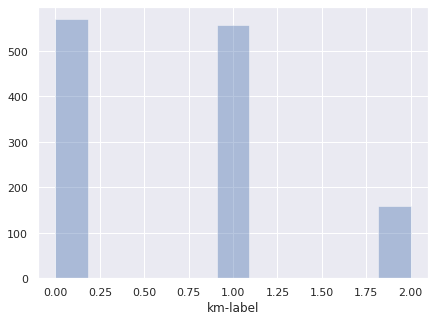

km-label     id
6          1  om_13
7          1  om_13
8          1  om_13
9          1  om_13
10         1  om_13

In [165]:
plt.figure(figsize=(7,5))
sns.distplot(df_data_selected['km-label'], kde=False)
plt.show()
df_data_selected[['km-label', 'id']].head()

# Step 3: Recom Lifestyle Factor

the shape of df: (1284, 6)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


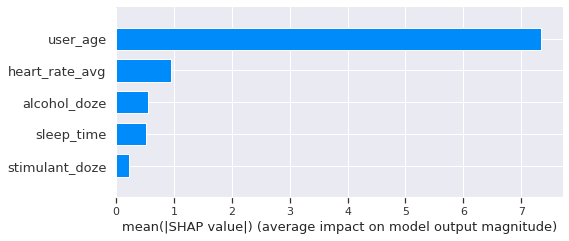

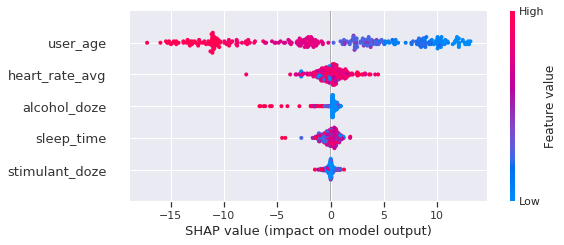

In [170]:
import shap
import copy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


def shapely_value(df):
    
    features = list(df.columns)
    features.remove('id')
    features.remove('score')
    features.remove('gmm-label')
    features.remove('km-label')
#     print(features)

    df3 = copy.deepcopy(df)
    X = data = df3[features]
    
#     data = X = df[features]
    features.extend(['id'])
#     print(features)
    df = df[features]
    print('the shape of df:', df.shape)
#     print('features are:', features)
    

    y = df3[['score']]
    y = np.array(y).reshape(1, -1)[0]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=2)

    rg = RandomForestRegressor(
        n_estimators=80,
        max_depth=25,
#         min_samples_split=5,
        random_state=42,
        criterion='mae')
    
    rg.fit(X_train, y_train)

#     print("Accuracy on train data: {:.2f}".format(rg.score(X_train, y_train)))
#     print("Accuracy on test data: {:.2f}".format(rg.score(
#         np.array(X_test).astype(int),
#         np.array(y_test).astype(int)
#     )))
#     you can try selecting features, then monitoring the test accuracy

    explainer = shap.TreeExplainer(rg)
    shap_values = explainer.shap_values(X_test)

    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test, plot_type="bar")
    shap.summary_plot(shap_values, X_test)
    shap.force_plot(explainer.expected_value, shap_values, X)


shapely_value(df_data_selected)

For the Cluster 0 in KMeans, we have:
the shape of df: (569, 6)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


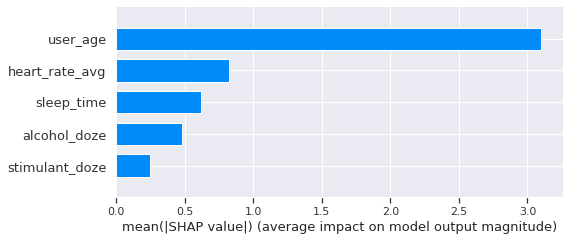

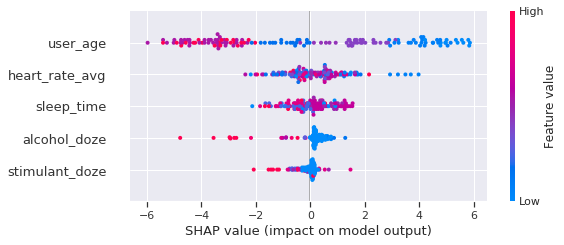

For the Cluster 1 in KMeans, we have:
the shape of df: (556, 6)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


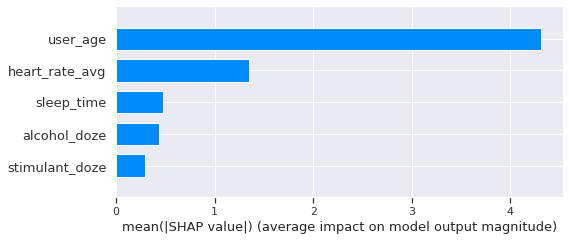

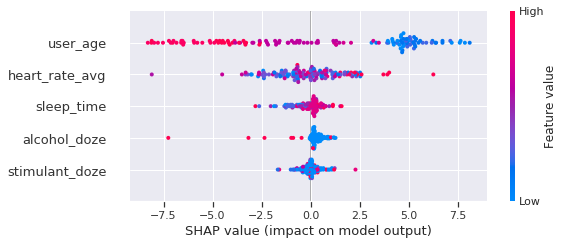

For the Cluster 2 in KMeans, we have:
the shape of df: (159, 6)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


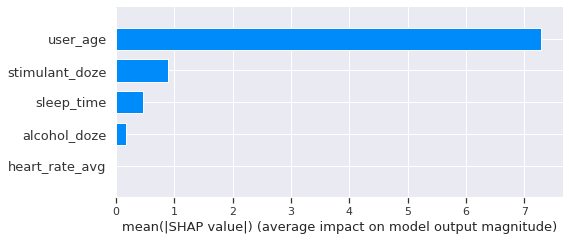

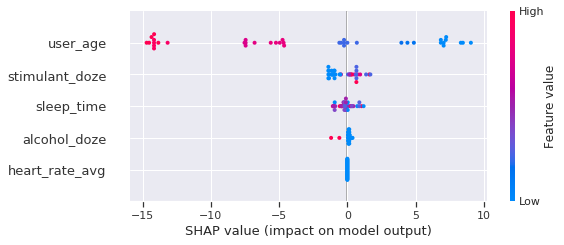

In [176]:
for label in range(n_clusters):
    print('For the Cluster', label, 'in KMeans, we have:')
    shapely_value(df_data_selected[df_data_selected['km-label']==label])

For the Cluster 0 in GMM, we have:
the shape of df: (956, 6)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


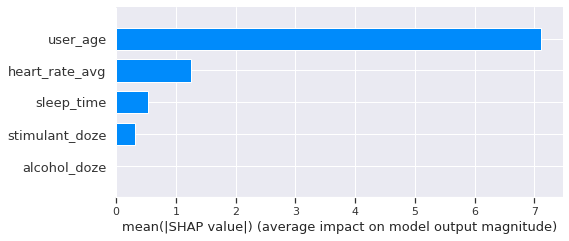

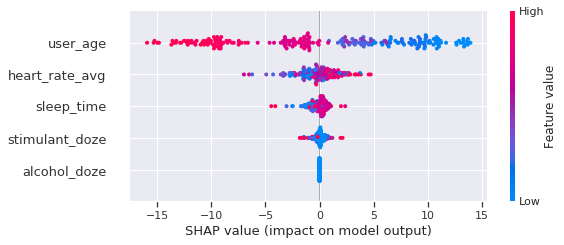

For the Cluster 1 in GMM, we have:
the shape of df: (169, 6)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


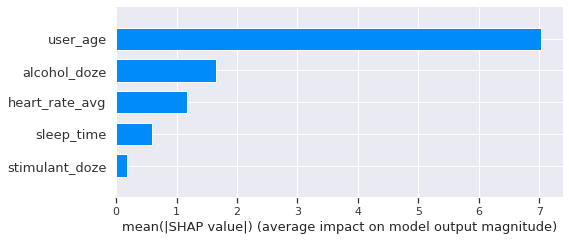

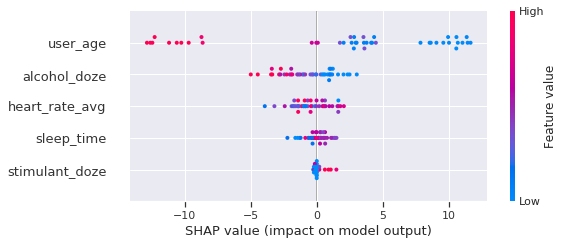

For the Cluster 2 in GMM, we have:
the shape of df: (159, 6)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


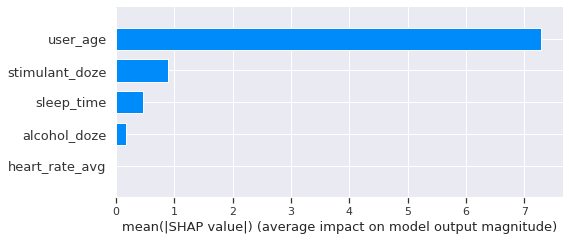

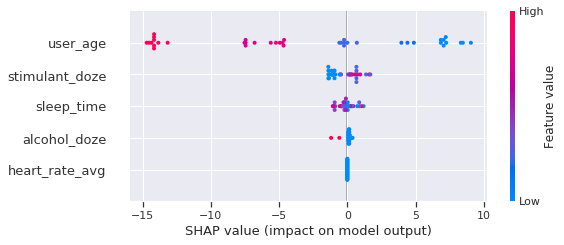

In [177]:
for label in range(n_clusters):
    print('For the Cluster', label, 'in GMM, we have:')
    shapely_value(df_data_selected[df_data_selected['gmm-label']==label])

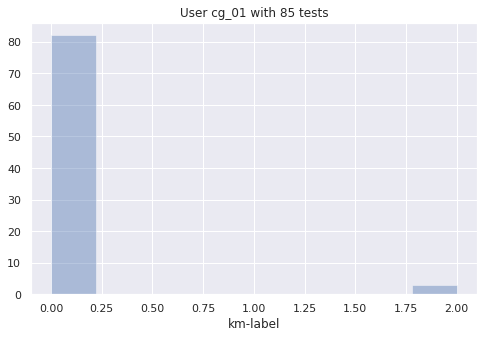

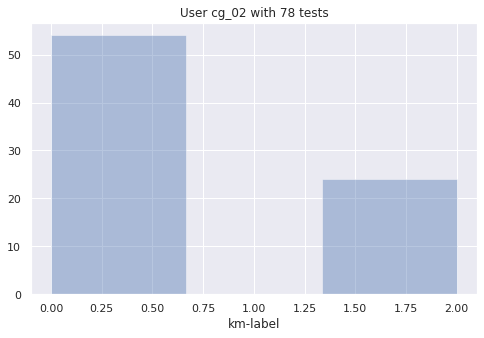

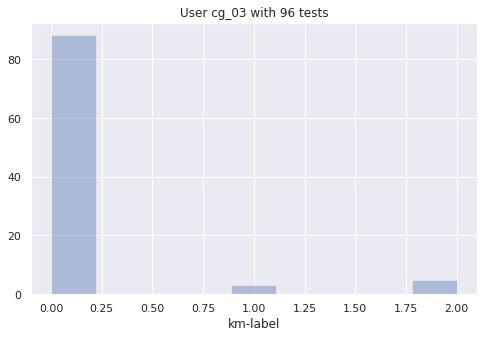

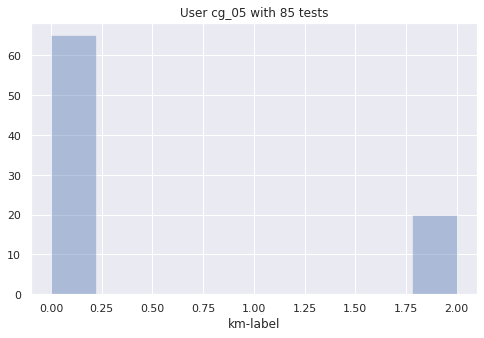

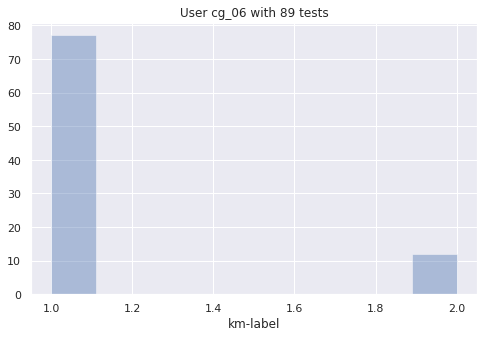

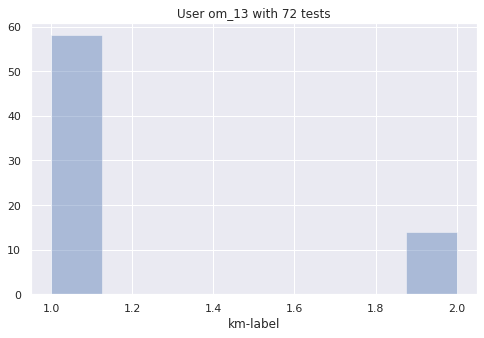

In [181]:
for user_id in ['cg_01', 'cg_02', 'cg_03',
                'cg_05', 'cg_06', 'om_13',
#                 'om_18', 'om_40', 'om_51'
               ]:
    plt.figure(figsize=(8,5))
    ax = sns.distplot(
        df_data_selected[df_data_selected.id==user_id]['km-label'],
        kde=False
    )
    ax.set_title('User ' + user_id + ' with ' + str(df_data_selected[df_data_selected.id==user_id].id.count()) + ' tests')
    plt.show()
    